In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader as pdr

In [ ]:
# Before running this cell run the below one.
# In case of RemoteDataError try this code then the cell below
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 5.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


     |████████████████████████████████| 109 kB 5.2 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2021-09-01')

df = pdr.get_data_yahoo("GOOG", start, end)

In [ ]:
print(df.shape)
df.head()

(2937, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,313.579620,310.954468,312.304413,312.204773,3927065.0,312.204773
2010-01-05,312.747742,309.609497,312.418976,310.829926,6031925.0,310.829926
2010-01-06,311.761444,302.047852,311.761444,302.994293,7987226.0,302.994293
2010-01-07,303.861053,295.218445,303.562164,295.940735,12876685.0,295.940735
2010-01-08,300.498657,293.455048,294.894653,299.885956,9484016.0,299.885956


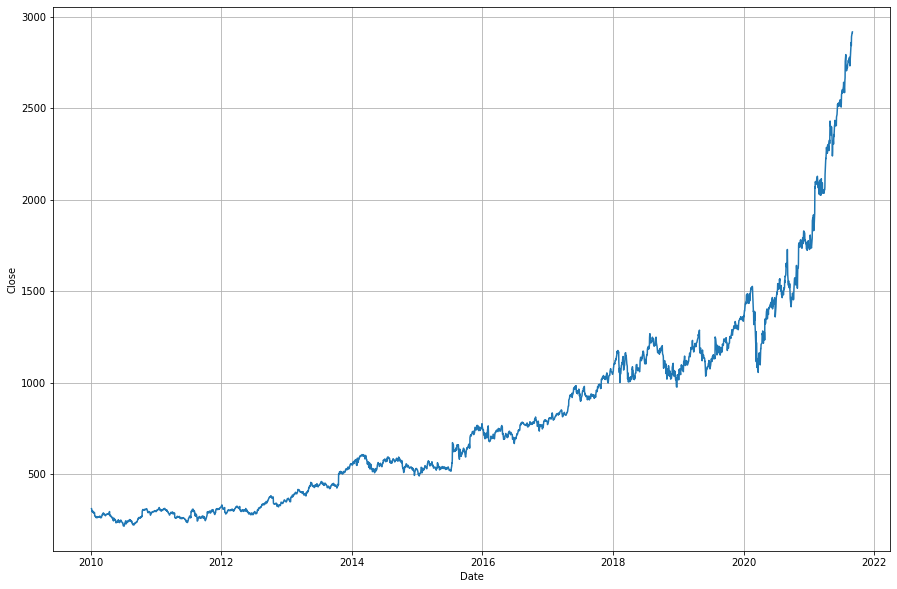

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=df, x='Date', y='Close');
plt.grid()

In [ ]:
close = df['Close'].to_numpy()
dates = df.index.to_numpy()
len(close)

2937

In [ ]:
# Train test split
TEST_SIZE = 0.2
n = len(dates)

dates_train = dates[:int(n * (1 - TEST_SIZE))]
close_train = close[:int(n * (1 - TEST_SIZE))]

dates_test = dates[int(n * (1 - TEST_SIZE)):]
close_test = close[int(n * (1 - TEST_SIZE)):]

len(close_train), len(close_test), len(dates_train), len(dates_test)

(2349, 588, 2349, 588)

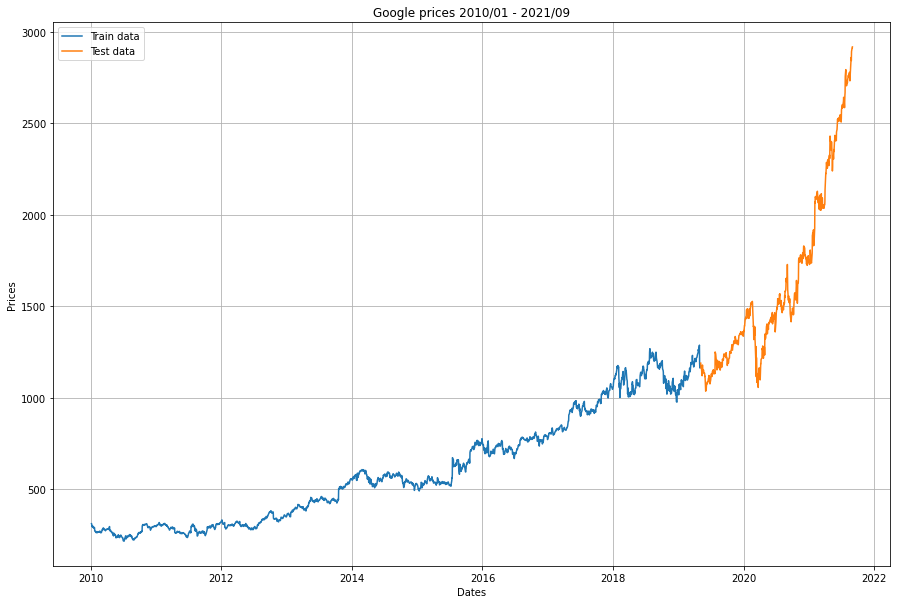

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_train, y=close_train, label='Train data');
sns.lineplot(x=dates_test, y=close_test, label='Test data');
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.title(f"Google prices {start.year}/0{start.month} - {end.year}/0{end.month}")
plt.grid()


## Metrics
During experiments below evaluation metrics will be used:
  * MAE - mean absolute error
  * RMSE - root mean square error
  * MASE - mean absolute scaled error

In [ ]:
# Define the function for calculating each metric
def model_results(y_true, y_pred):
  # additioanl cast the arguments with float32
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)
  
  # There are built in functions in tensorflow matrics class
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))


  # Mean scaled error
  x = tf.reduce_mean(tf.abs(y_true - y_pred))
  y = tf.reduce_mean(tf.abs(y_true[1:] - y_pred[:-1]))
  mase = (x / y).numpy()

  return {"mae": mae.numpy(), 
          'rmse': rmse.numpy(), 
          "mase": mase}

##Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:

Horizon = number of timesteps into the future we're going to predict

Window size = number of timesteps we're going to use to predict horizon
Modelling experiments we're running:

 * 0 Naïve model (baseline)

 * 1 Moving Average

 * 2 Dense model, horizon = 1, window = 7

 * 3 Same as 1, horizon = 1, window = 30

 * 4 Conv1D

 * 5 LSTM

 * 6 N-BEATs Algorithm

 * 7 Ensemble (multiple models optimized on different loss functions)

 * 8 Future prediction model (model to predict future values)

 * 9 Same as 1 (but with turkey data introduced)

# Method 0: Naive model (baseline)

$ \hat{y}_{t} = {y}_{t-1}$

The approach is simple the next day price is equal to the price of the previous day

Naive Model results and plot: 
 {'mae': 20.201494, 'rmse': 29.204773, 'mase': 0.7299321}


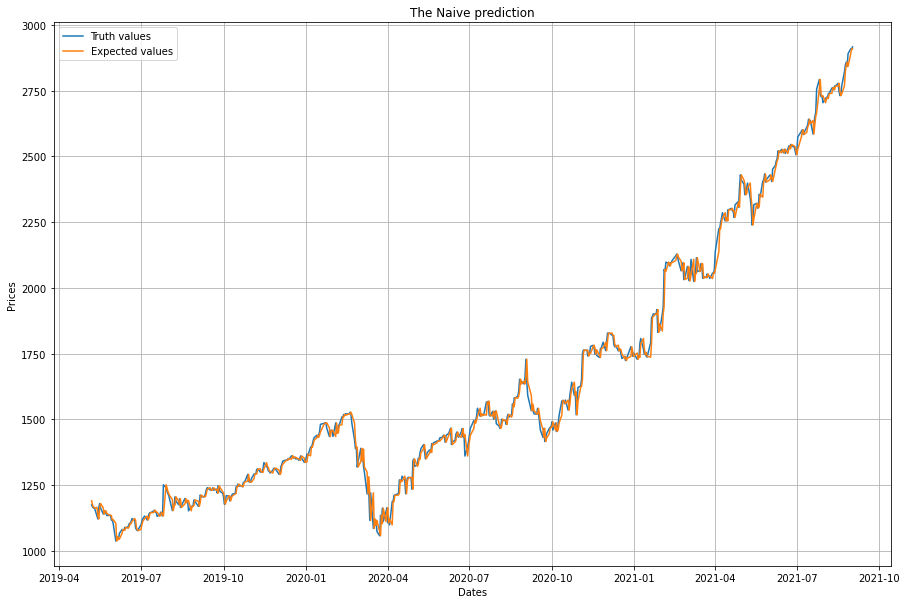

In [ ]:
y_test = close_test[1:]
y_pred = close_test[:-1]
assert len(y_test) == len(y_pred)

model0_res = model_results(y_true=np.squeeze(y_test),
                           y_pred=np.squeeze(y_pred))
print(f"Naive Model results and plot: \n {model0_res}")
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_test[1:], y=y_test, label='Truth values')
sns.lineplot(x=dates_test[1:], y=y_pred, label='Expected values')
plt.title("The Naive prediction")
plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()


# Model 1: Practical approaches
 * Moving average



### Moving average

Moving Average(all) results and plot: 
 {'mae': 352.82217, 'rmse': 492.735, 'mase': 0.9953817}


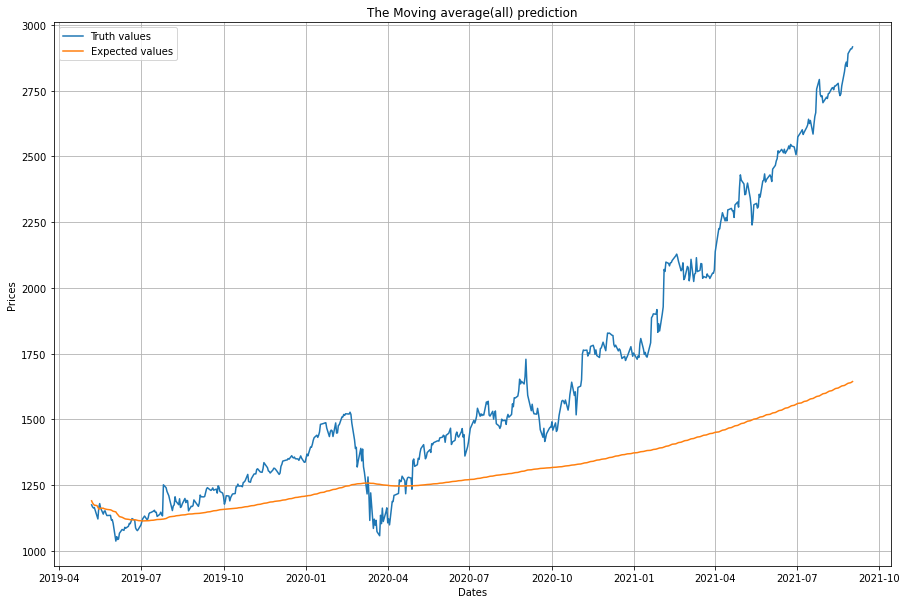

In [ ]:
y_pred = np.cumsum(np.array(close_test)) / np.arange(1, len(close_test) + 1)
y_pred = y_pred[:-1]
# print(len(y_pred), len(y_test))
assert len(y_test) == len(y_pred)

model1_ma = model_results(y_true=y_test,
                           y_pred=(y_pred))
print(f"Moving Average(all) results and plot: \n {model1_ma}")
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_test[1:], y=y_test, label='Truth values')
sns.lineplot(x=dates_test[1:], y=y_pred, label='Expected values')
plt.title("The Moving average(all) prediction")
plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In [ ]:
# define the function which will take window size of the previous prices and predicts the next day's price with average of chosen values
def moving_average_window(x, window_size):
  x = pd.Series(x)
  return x.rolling(window_size).mean()

Moving average results and plot: 
 {'mae': 21.550978, 'rmse': 30.06116, 'mase': 0.733629}


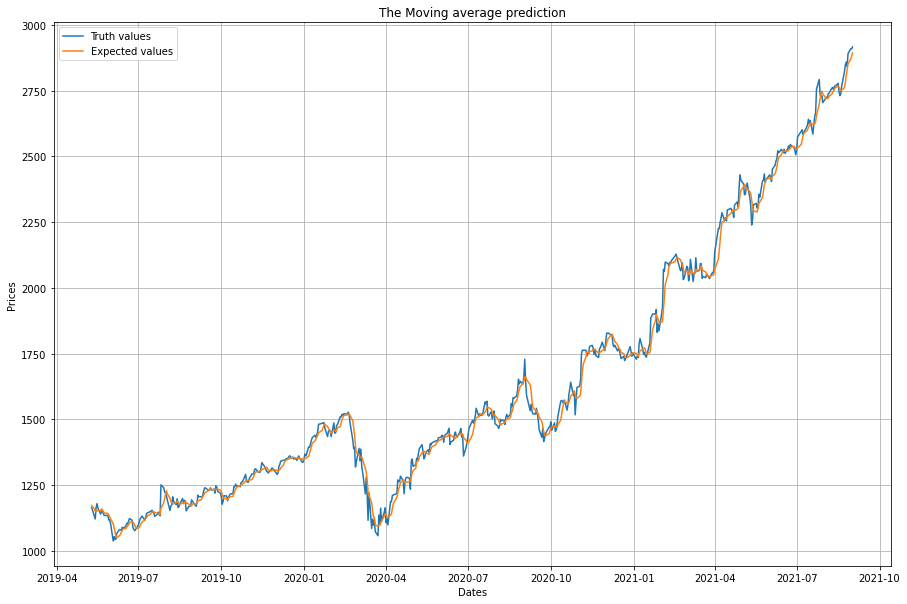

In [ ]:
WINDOW_SIZE = 5
y_pred = moving_average_window(close_test, WINDOW_SIZE)
y_pred = y_pred[WINDOW_SIZE-1:]
y_test = close_test[WINDOW_SIZE-1:]
model1_maw = model_results(y_true=y_test,
                           y_pred=y_pred)
print(f"Moving average results and plot: \n {model1_maw}")
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_test[WINDOW_SIZE-1:], y=y_test, label='Truth values')
sns.lineplot(x=dates_test[WINDOW_SIZE-1:], y=y_pred, label='Expected values')
plt.title("The Moving average prediction")
plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In [ ]:
# Try simple moving average with different window_sizes
windows = [3, 5, 7, 10, 30]
for i in range(len(windows)):
  y_pred = moving_average_window(close_test, windows[i])
  y_pred = y_pred[windows[i]-1:]
  y_test = close_test[windows[i]-1:]
  res = model_results(y_true=y_test,
                            y_pred=y_pred)
  print(f"The Results with window size {windows[i]} \n {res} \n")

The Results with window size 3 
 {'mae': 14.646487, 'rmse': 20.685097, 'mase': 0.5971596} 

The Results with window size 5 
 {'mae': 21.550978, 'rmse': 30.06116, 'mase': 0.733629} 

The Results with window size 7 
 {'mae': 27.097878, 'rmse': 37.328754, 'mase': 0.80697787} 

The Results with window size 10 
 {'mae': 34.05648, 'rmse': 46.071053, 'mase': 0.8463902} 

The Results with window size 30 
 {'mae': 72.46079, 'rmse': 92.630424, 'mase': 0.9459305} 



Moving average 3 results and plot: 
 {'mae': 14.646487, 'rmse': 20.685097, 'mase': 0.5971596}


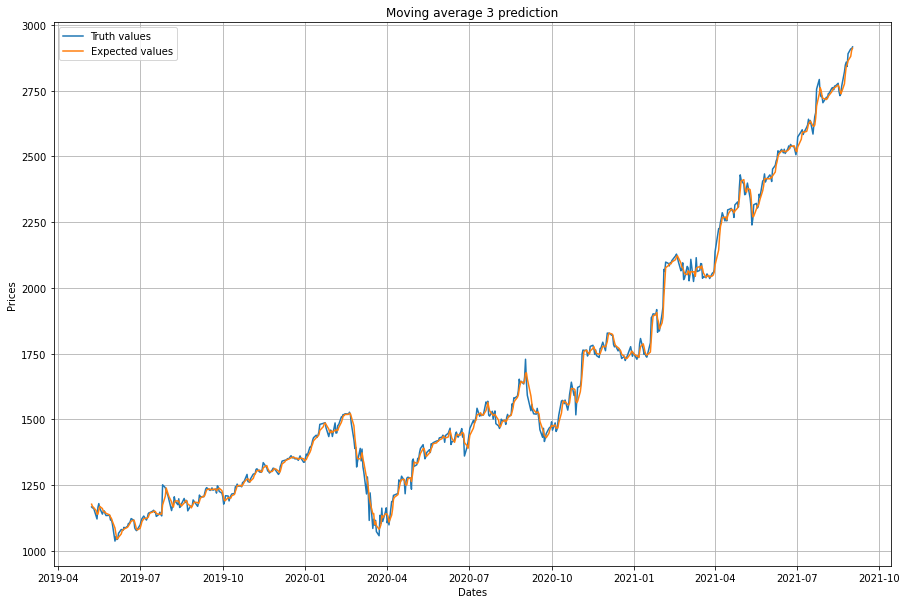

In [ ]:
# the best result was from window size: 3
WINDOW_SIZE = 3
y_pred = moving_average_window(close_test, WINDOW_SIZE)
y_pred = y_pred[WINDOW_SIZE-1:]
y_test = close_test[WINDOW_SIZE-1:]
model1_maw = model_results(y_true=y_test,
                           y_pred=y_pred)
print(f"Moving average {WINDOW_SIZE} results and plot: \n {model1_maw}")
plt.figure(figsize=(15, 10))
sns.lineplot(x=dates_test[WINDOW_SIZE-1:], y=y_test, label='Truth values')
sns.lineplot(x=dates_test[WINDOW_SIZE-1:], y=y_pred, label='Expected values')
plt.title(f"Moving average {WINDOW_SIZE} prediction")
plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

# Model 2: Dense layer

### Creating datasets
From given window sizes and horizons dataset should be created

For example if window size is 5 and horizon is 1 then we have
dataset with this corresponding indexes

[[0], [1], [2], [3], [4]] -> [5]

[[1], [2], [3], [4], [5]] -> [6]

...

[[50], [51], [52], [53], [54]] -> [55]

...

[[1000], [1001], [1002], [1003], [1004]] -> [1005]

However for creating that type dataset if data will be relativly large with 'for' loop it will take a lot of time for creating the dataset

In [ ]:
# example of window sliding indexing
WINDOW_SIZE = 7
HORIZON = 1
x = np.arange(0, 35)
steps = np.expand_dims(np.arange(WINDOW_SIZE + HORIZON), axis=0)
indexes = steps + (np.expand_dims(np.arange(len(x) - (WINDOW_SIZE + HORIZON - 1)), axis=0)).T
indexes

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 1,  2,  3,  4,  5,  6,  7,  8],
       [ 2,  3,  4,  5,  6,  7,  8,  9],
       [ 3,  4,  5,  6,  7,  8,  9, 10],
       [ 4,  5,  6,  7,  8,  9, 10, 11],
       [ 5,  6,  7,  8,  9, 10, 11, 12],
       [ 6,  7,  8,  9, 10, 11, 12, 13],
       [ 7,  8,  9, 10, 11, 12, 13, 14],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [ 9, 10, 11, 12, 13, 14, 15, 16],
       [10, 11, 12, 13, 14, 15, 16, 17],
       [11, 12, 13, 14, 15, 16, 17, 18],
       [12, 13, 14, 15, 16, 17, 18, 19],
       [13, 14, 15, 16, 17, 18, 19, 20],
       [14, 15, 16, 17, 18, 19, 20, 21],
       [15, 16, 17, 18, 19, 20, 21, 22],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [17, 18, 19, 20, 21, 22, 23, 24],
       [18, 19, 20, 21, 22, 23, 24, 25],
       [19, 20, 21, 22, 23, 24, 25, 26],
       [20, 21, 22, 23, 24, 25, 26, 27],
       [21, 22, 23, 24, 25, 26, 27, 28],
       [22, 23, 24, 25, 26, 27, 28, 29],
       [23, 24, 25, 26, 27, 28, 29, 30],
       [24, 25, 

In [ ]:
# defining the function which will create dataset

def dataset_from_timeseries(x, window_size, horizon):
  cols = []
  for i in range(window_size):
    cols.append(f'x_{i}')
  cols.append('y')
  # Create one row of steps as nested array
  window_steps = np.expand_dims(np.arange(window_size + horizon), axis=0)
  # Create transposed matrix of indexes
  indexes = window_steps + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T
  # Creating pandas dataframe with indexes of x then putting columns
  df = pd.DataFrame(x[indexes])
  df.columns = cols
  return df


In [ ]:
WINDOW_SIZE = 7
HORIZON = 1
train_dataset = dataset_from_timeseries(x=close_train, 
                                        window_size=WINDOW_SIZE,
                                        horizon=HORIZON)
train_dataset

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,y
0,312.204773,310.829926,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822
1,310.829926,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669
2,302.994293,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053
3,295.940735,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053,292.712830
4,299.885956,299.432648,294.137512,292.448822,293.823669,288.917053,292.712830,289.121307
...,...,...,...,...,...,...,...,...
2337,1236.339966,1236.369995,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956
2338,1236.369995,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980
2339,1248.839966,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980,1168.079956
2340,1264.550049,1256.000000,1263.449951,1272.180054,1287.579956,1188.479980,1168.079956,1162.609985


In [ ]:
test_dataset = dataset_from_timeseries(close_test,
                                       WINDOW_SIZE,
                                       HORIZON)
train_dataset.shape, test_dataset.shape, 

((2342, 8), (581, 8))

Dataset's instances are not large, that is why train_test split will be taken 10%

In [ ]:
# Making train test datasets
def train_test_datasets(x, window_size, horizon, test_split):
  df = dataset_from_timeseries(x, window_size, horizon).to_numpy()
  split = 1 - int(test_split * df.shape[0])
  return df[:split, :-1], df[split:, :-1], df[:split, -1], df[split:, -1]

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1
TEST_SIZE = 0.1
x_train, x_test, y_train, y_test = train_test_datasets(x=close,
                                                       window_size=WINDOW_SIZE,
                                                       horizon=HORIZON,
                                                       test_split=TEST_SIZE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2638, 7), (292, 7), (2638,), (292,))

### Making model fitting checkpoints

In [ ]:
import os 

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True)

### Making Model

In [ ]:
BATCH_SIZE = 64
inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer1')(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model2 = tf.keras.Model(inputs, outputs, name='model2_dense')

model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model2.summary()

Model: "model2_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 128)               1024      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the first model

hist2 = model2.fit(x_train, 
                   y_train, 
                   verbose=0,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10.,
                   callbacks=create_model_checkpoint("1_dense_layer_128"))

INFO:tensorflow:Assets written to: model_experiments/1_dense_layer_128/assets


In [ ]:
model2 = tf.keras.models.load_model("model_experiments/1_dense_layer_128")
model2.evaluate(x_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 146.3189 - mae: 146.3189


[146.31886291503906, 146.31886291503906]

In [ ]:
y_pred = model2.predict(x_test)
model2_res = model_results(y_test, tf.squeeze(y_pred))
model2_res

{'mae': 146.31886, 'mase': 0.96897334, 'rmse': 161.12321}

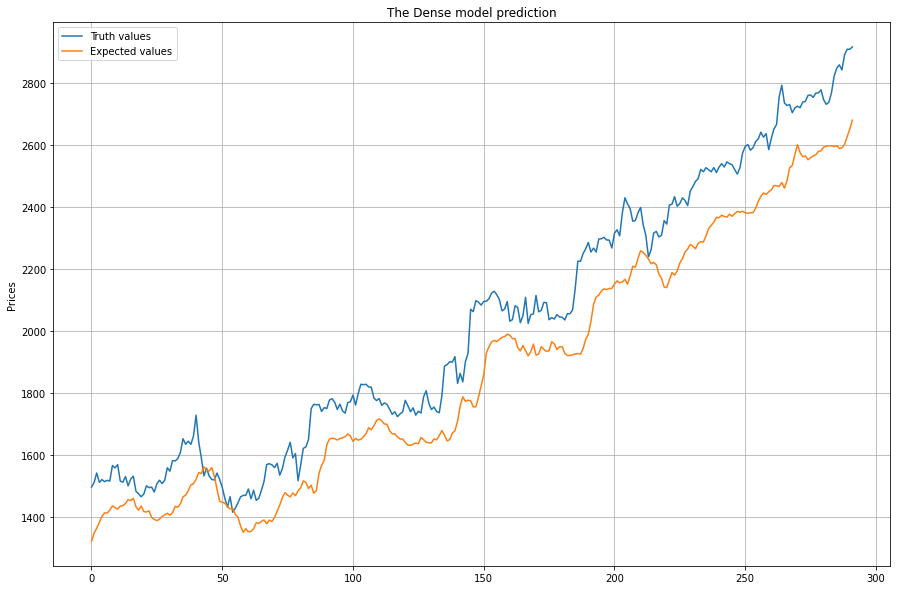

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

Autocorrelation problem. Looks like model has lags of one day, it predicts the actual price tomorrow, e.g. for the day number 5 the more accurate price is predicted in the 6th day.


# Model 3: 
Same model 2 with window_size=30, horizon=1 

In [ ]:
WINDOW_SIZE = 30
x_train, x_test, y_train, y_test = train_test_datasets(close,
                                                       WINDOW_SIZE,
                                                       HORIZON,
                                                       TEST_SIZE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2618, 30), (289, 30), (2618,), (289,))

In [ ]:
inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
x = tf.keras.layers.Dense(128, activation='relu', name='dense_layer1')(inputs)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model3 = tf.keras.Model(inputs, outputs, name='model3_dense')

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model3.summary()

Model: "model3_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 30)]              0         
_________________________________________________________________
dense_layer1 (Dense)         (None, 128)               3968      
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the first model
BATCH_SIZE = 64
hist3 = model3.fit(x_train, 
                   y_train, 
                   verbose=1,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=5,
                   )

Epoch 1/100
41/41 [==============================] - 1s 7ms/step - loss: 70.2494 - mae: 70.2494 - val_loss: 56.6265 - val_mae: 56.6265
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 17.4795 - mae: 17.4795 - val_loss: 47.9994 - val_mae: 47.9994
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 17.8694 - mae: 17.8694 - val_loss: 48.8341 - val_mae: 48.8341
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 15.9102 - mae: 15.9102 - val_loss: 44.5355 - val_mae: 44.5355
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 15.8219 - mae: 15.8219 - val_loss: 48.7006 - val_mae: 48.7006
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 14.6142 - mae: 14.6142 - val_loss: 48.6821 - val_mae: 48.6821
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 16.6401 - mae: 16.6401 - val_loss: 42.7067 - val_mae: 42.7067
Epoch 8/100
41/41 [==============================] - 0s

In [ ]:
model3.evaluate(x_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 27.1261 - mae: 27.1261


[27.126117706298828, 27.126117706298828]

{'mae': 27.126118, 'rmse': 35.895275, 'mase': 0.7823087}


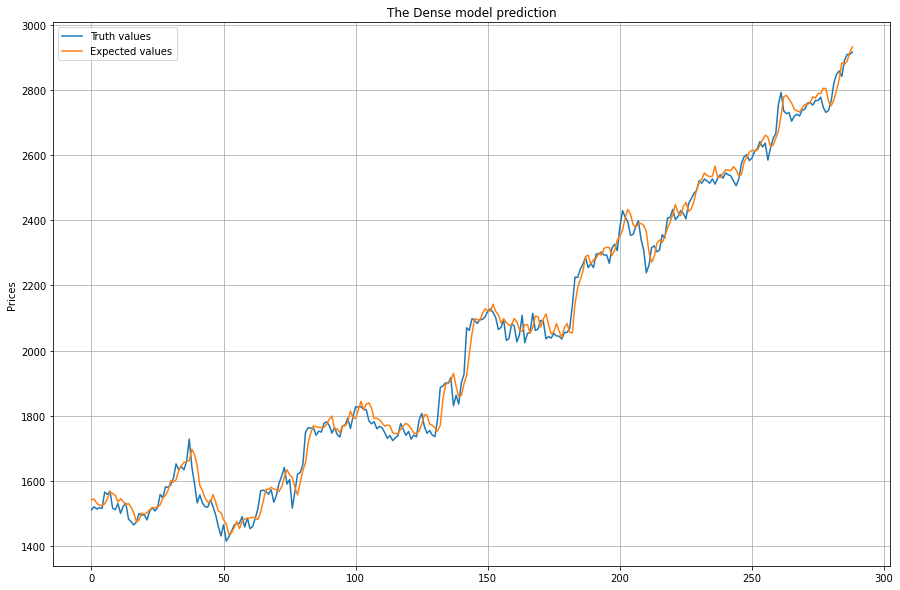

In [ ]:
y_pred = model3.predict(x_test)
model3_res = model_results(y_test, tf.squeeze(y_pred))
print(model3_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Dense model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

# Model 4: Conv1D

For this model and after the window size=7 and horizon=1 will be used and 20% as test set

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1
TEST_SIZE = 0.2
x_train, x_test, y_train, y_test = train_test_datasets(x=close,
                                                       window_size=WINDOW_SIZE,
                                                       horizon=HORIZON,
                                                       test_split=TEST_SIZE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2345, 7), (585, 7), (2345,), (585,))

In [ ]:
model0_res

{'mae': 20.201494, 'mase': 0.7299321, 'rmse': 29.204773}

In [ ]:
# expanding layer
expanding_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1), name='expand_layer')

inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
# x = tf.expand_dims(inputs, axis=1)
x = expanding_layer(inputs)
x = tf.keras.layers.Conv1D(64, kernel_size=3,
                           strides=1, padding='same',
                           activation='relu', name='conv1d_layer')(x)

x = tf.keras.layers.GlobalAveragePooling1D(name='global_average_layer')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model4 = tf.keras.Model(inputs, outputs, name='model4_dense')

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               metrics=['mae'])
model4.summary()

Model: "model4_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
expand_layer (Lambda)        (None, 1, 7)              0         
_________________________________________________________________
conv1d_layer (Conv1D)        (None, 1, 64)             1408      
_________________________________________________________________
global_average_layer (Global (None, 64)                0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 65        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist4 = model4.fit(x_train, 
                   y_train, 
                   verbose=0,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10,
                   callbacks=create_model_checkpoint("conv1d_model"))

INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model/assets
INFO:tensorflow:Assets written to: model_experiment

In [ ]:
model4 = tf.keras.models.load_model("model_experiments/conv1d_model")
model4.evaluate(x_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 20.8321 - mae: 20.8321


[20.83208656311035, 20.83208656311035]

{'mae': 20.832087, 'rmse': 29.919538, 'mase': 0.74087405}


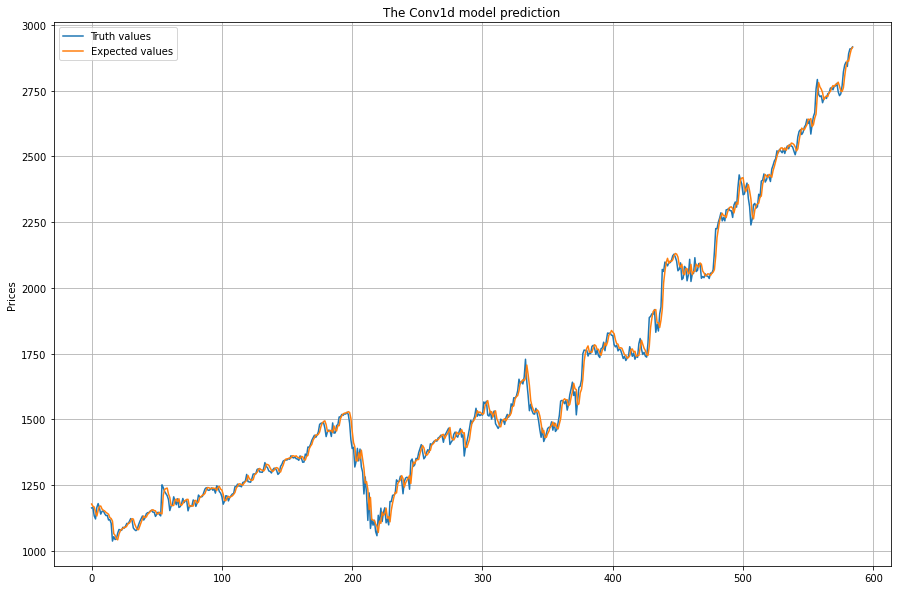

In [ ]:
y_pred = model4.predict(x_test)
model4_res = model_results(y_test, tf.squeeze(y_pred))
print(model4_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Conv1d model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In [ ]:
# try other conv1d layer with different variables

inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
x = expanding_layer(inputs)
x = tf.keras.layers.Conv1D(128, kernel_size=WINDOW_SIZE,
                           strides=1, padding='causal',
                           activation='linear', name='conv1d_layer')(x)

x = tf.keras.layers.GlobalMaxPooling1D(name='global_max_layer')(x)
outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model5 = tf.keras.Model(inputs, outputs, name='model5_dense')

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               )
model5.summary()

Model: "model5_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
expand_layer (Lambda)        (None, 1, 7)              0         
_________________________________________________________________
conv1d_layer (Conv1D)        (None, 1, 128)            6400      
_________________________________________________________________
global_max_layer (GlobalMaxP (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist5 = model5.fit(x_train, 
                   y_train, 
                   verbose=0,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10,
                   callbacks=create_model_checkpoint("conv1d_model2"))

INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: model_experiments/conv1d_model2/assets
INFO:tensorflow:Assets written to: mod

In [ ]:
model5 = tf.keras.models.load_model("model_experiments/conv1d_model2")
model5.evaluate(x_test, y_test)

19/19 [==============================] - 0s 3ms/step - loss: 19.8895


19.889507293701172

{'mae': 19.889507, 'rmse': 28.821043, 'mase': 0.7231514}


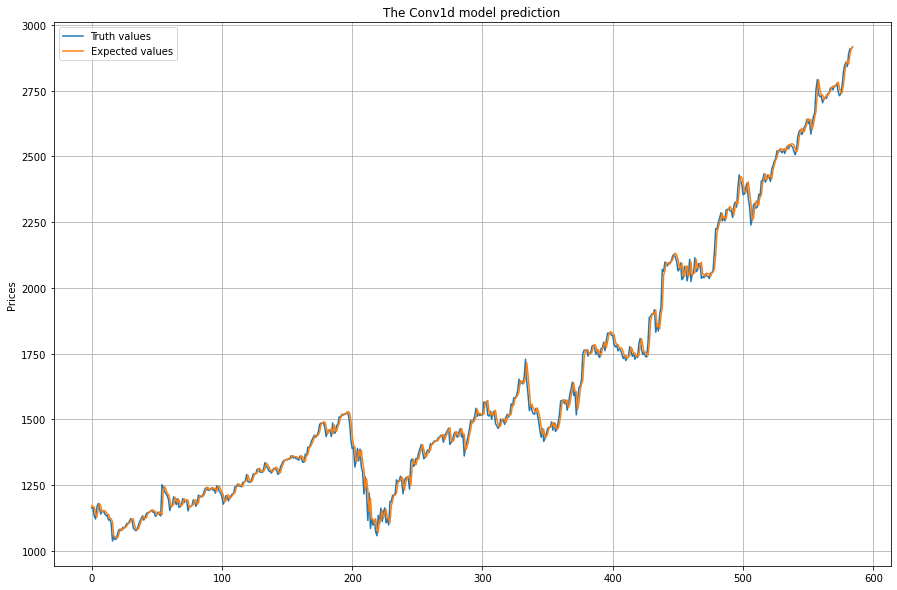

In [ ]:
y_pred = model5.predict(x_test)
model5_res = model_results(y_test, tf.squeeze(y_pred))
print(model5_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Conv1d model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In [ ]:
for i in range(10):
  print('Actual', y_test[i], 'Predicted', y_pred[i][0], sep="--")

Actual--1162.3800048828125--Predicted--1171.5073
Actual--1164.27001953125--Predicted--1166.0873
Actual--1132.030029296875--Predicted--1166.485
Actual--1120.43994140625--Predicted--1142.643
Actual--1164.2099609375--Predicted--1127.3198
Actual--1178.97998046875--Predicted--1157.3787
Actual--1162.300048828125--Predicted--1179.263
Actual--1138.8499755859375--Predicted--1170.2438
Actual--1149.6300048828125--Predicted--1147.5562
Actual--1151.4200439453125--Predicted--1149.7467


# Model 5: LSTM

In [ ]:
inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
x = expanding_layer(inputs)
x = tf.keras.layers.LSTM(128, name='lstm_layer')(x)
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(x)

outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model6 = tf.keras.Model(inputs, outputs, name='model6_lstm')

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               )
model6.summary()

Model: "model6_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
expand_layer (Lambda)        (None, 1, 7)              0         
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               69632     
_________________________________________________________________
batch_norm_layer (BatchNorma (None, 128)               512       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 70,273
Trainable params: 70,017
Non-trainable params: 256
_________________________________________________________________


In [ ]:
hist6 = model6.fit(x_train, 
                   y_train, 
                   verbose=1,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10,
                   callbacks=create_model_checkpoint("lstm_model"))

Epoch 1/100
37/37 [==============================] - 3s 21ms/step - loss: 605.1301 - val_loss: 1646.3241


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 2/100
37/37 [==============================] - 0s 6ms/step - loss: 604.1004 - val_loss: 1645.2699


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 3/100
37/37 [==============================] - 0s 6ms/step - loss: 602.3168 - val_loss: 1642.8206


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 4/100
37/37 [==============================] - 0s 6ms/step - loss: 599.6610 - val_loss: 1639.7284


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 5/100
37/37 [==============================] - 0s 6ms/step - loss: 596.0860 - val_loss: 1635.7308


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 6/100
37/37 [==============================] - 0s 6ms/step - loss: 591.5741 - val_loss: 1630.8159


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 7/100
37/37 [==============================] - 0s 8ms/step - loss: 586.1214 - val_loss: 1624.9518


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 8/100
37/37 [==============================] - 0s 6ms/step - loss: 579.7314 - val_loss: 1618.1924


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 9/100
37/37 [==============================] - 0s 6ms/step - loss: 572.4110 - val_loss: 1610.4734


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 10/100
37/37 [==============================] - 0s 6ms/step - loss: 564.1697 - val_loss: 1601.8258


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 11/100
37/37 [==============================] - 0s 7ms/step - loss: 555.0184 - val_loss: 1592.2723


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 12/100
37/37 [==============================] - 0s 8ms/step - loss: 544.9681 - val_loss: 1581.8147


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 13/100
37/37 [==============================] - 0s 7ms/step - loss: 534.0309 - val_loss: 1570.4672


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 14/100
37/37 [==============================] - 0s 6ms/step - loss: 522.2182 - val_loss: 1558.2397


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 15/100
37/37 [==============================] - 0s 6ms/step - loss: 509.5422 - val_loss: 1545.1447


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 16/100
37/37 [==============================] - 0s 6ms/step - loss: 496.0142 - val_loss: 1531.1981


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 17/100
37/37 [==============================] - 0s 7ms/step - loss: 481.6461 - val_loss: 1504.7170


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 18/100
37/37 [==============================] - 0s 7ms/step - loss: 466.4492 - val_loss: 1510.5459
Epoch 19/100
37/37 [==============================] - 0s 6ms/step - loss: 450.4345 - val_loss: 1492.8287


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 20/100
37/37 [==============================] - 0s 6ms/step - loss: 433.6131 - val_loss: 1474.4139


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 21/100
37/37 [==============================] - 0s 6ms/step - loss: 415.9958 - val_loss: 1455.1202


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 22/100
37/37 [==============================] - 0s 8ms/step - loss: 397.5926 - val_loss: 1435.2189


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 23/100
37/37 [==============================] - 0s 7ms/step - loss: 378.4978 - val_loss: 1744.9885
Epoch 24/100
37/37 [==============================] - 0s 7ms/step - loss: 359.6656 - val_loss: 1671.6251
Epoch 25/100
37/37 [==============================] - 0s 6ms/step - loss: 342.5468 - val_loss: 1585.7208
Epoch 26/100
37/37 [==============================] - 0s 6ms/step - loss: 328.2438 - val_loss: 1514.0902
Epoch 27/100
37/37 [==============================] - 0s 8ms/step - loss: 316.8388 - val_loss: 1489.0751
Epoch 28/100
37/37 [==============================] - 0s 7ms/step - loss: 308.8011 - val_loss: 1435.1183


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 29/100
37/37 [==============================] - 0s 8ms/step - loss: 302.8017 - val_loss: 1392.2926


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 30/100
37/37 [==============================] - 0s 7ms/step - loss: 297.4621 - val_loss: 1357.4484


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 31/100
37/37 [==============================] - 0s 8ms/step - loss: 292.5642 - val_loss: 1329.5094


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 32/100
37/37 [==============================] - 0s 6ms/step - loss: 287.8655 - val_loss: 1306.5732


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 33/100
37/37 [==============================] - 0s 6ms/step - loss: 283.2751 - val_loss: 1286.7877


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 34/100
37/37 [==============================] - 0s 7ms/step - loss: 279.0528 - val_loss: 1268.7471


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 35/100
37/37 [==============================] - 0s 6ms/step - loss: 275.1085 - val_loss: 1253.6561


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 36/100
37/37 [==============================] - 0s 6ms/step - loss: 271.4727 - val_loss: 1238.7794


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 37/100
37/37 [==============================] - 0s 8ms/step - loss: 267.6526 - val_loss: 1226.3817


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 38/100
37/37 [==============================] - 0s 6ms/step - loss: 264.2425 - val_loss: 1213.1851


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 39/100
37/37 [==============================] - 0s 7ms/step - loss: 261.0839 - val_loss: 1202.5184


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 40/100
37/37 [==============================] - 0s 6ms/step - loss: 258.6757 - val_loss: 1191.2576


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 41/100
37/37 [==============================] - 0s 6ms/step - loss: 256.6224 - val_loss: 1182.0734


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 42/100
37/37 [==============================] - 0s 6ms/step - loss: 254.7722 - val_loss: 1172.2708


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 43/100
37/37 [==============================] - 0s 8ms/step - loss: 252.7352 - val_loss: 1162.9615


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 44/100
37/37 [==============================] - 0s 7ms/step - loss: 250.7861 - val_loss: 1153.0938


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 45/100
37/37 [==============================] - 0s 7ms/step - loss: 248.7101 - val_loss: 1142.7922


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 46/100
37/37 [==============================] - 0s 6ms/step - loss: 246.7051 - val_loss: 1133.0273


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 47/100
37/37 [==============================] - 0s 6ms/step - loss: 244.7297 - val_loss: 1124.1812


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 48/100
37/37 [==============================] - 0s 7ms/step - loss: 243.3710 - val_loss: 1115.9143


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 49/100
37/37 [==============================] - 0s 7ms/step - loss: 242.2304 - val_loss: 1111.0212


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 50/100
37/37 [==============================] - 0s 6ms/step - loss: 241.4292 - val_loss: 1104.4508


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 51/100
37/37 [==============================] - 0s 7ms/step - loss: 241.0450 - val_loss: 1101.9713


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 52/100
37/37 [==============================] - 0s 6ms/step - loss: 240.6568 - val_loss: 1101.3917


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 53/100
37/37 [==============================] - 0s 7ms/step - loss: 240.2094 - val_loss: 1097.4615


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 54/100
37/37 [==============================] - 0s 7ms/step - loss: 239.9287 - val_loss: 1095.8480


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 55/100
37/37 [==============================] - 0s 6ms/step - loss: 239.7688 - val_loss: 1093.8762


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 56/100
37/37 [==============================] - 0s 6ms/step - loss: 239.2520 - val_loss: 1093.0387


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 57/100
37/37 [==============================] - 0s 7ms/step - loss: 239.0739 - val_loss: 1093.7859
Epoch 58/100
37/37 [==============================] - 0s 7ms/step - loss: 238.5570 - val_loss: 1091.2400


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 59/100
37/37 [==============================] - 0s 6ms/step - loss: 238.3835 - val_loss: 1091.0261


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 60/100
37/37 [==============================] - 0s 8ms/step - loss: 237.9248 - val_loss: 1089.3923


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 61/100
37/37 [==============================] - 0s 6ms/step - loss: 237.7319 - val_loss: 1088.5677


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 62/100
37/37 [==============================] - 0s 6ms/step - loss: 237.5105 - val_loss: 1087.6466


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 63/100
37/37 [==============================] - 0s 6ms/step - loss: 237.0300 - val_loss: 1087.2511


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 64/100
37/37 [==============================] - 0s 6ms/step - loss: 236.7173 - val_loss: 1090.0886
Epoch 65/100
37/37 [==============================] - 0s 6ms/step - loss: 236.4183 - val_loss: 1086.9423


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 66/100
37/37 [==============================] - 0s 7ms/step - loss: 236.0174 - val_loss: 1085.8342


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 67/100
37/37 [==============================] - 0s 6ms/step - loss: 235.7300 - val_loss: 1084.6794


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 68/100
37/37 [==============================] - 0s 6ms/step - loss: 235.4004 - val_loss: 1083.7983


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 69/100
37/37 [==============================] - 0s 7ms/step - loss: 235.0056 - val_loss: 1084.2582
Epoch 70/100
37/37 [==============================] - 0s 6ms/step - loss: 234.6745 - val_loss: 1083.2627


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 71/100
37/37 [==============================] - 0s 6ms/step - loss: 234.4448 - val_loss: 1082.1592


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 72/100
37/37 [==============================] - 0s 6ms/step - loss: 233.8864 - val_loss: 1082.1138


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 73/100
37/37 [==============================] - 0s 6ms/step - loss: 233.5975 - val_loss: 1082.1545
Epoch 74/100
37/37 [==============================] - 0s 7ms/step - loss: 233.3451 - val_loss: 1080.7035


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 75/100
37/37 [==============================] - 0s 7ms/step - loss: 232.8732 - val_loss: 1081.7389
Epoch 76/100
37/37 [==============================] - 0s 6ms/step - loss: 232.4078 - val_loss: 1080.1179


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 77/100
37/37 [==============================] - 0s 7ms/step - loss: 232.0312 - val_loss: 1078.5928


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 78/100
37/37 [==============================] - 0s 6ms/step - loss: 231.7173 - val_loss: 1077.9867


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 79/100
37/37 [==============================] - 0s 8ms/step - loss: 231.6987 - val_loss: 1077.8838


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 80/100
37/37 [==============================] - 0s 6ms/step - loss: 231.1260 - val_loss: 1077.3071


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 81/100
37/37 [==============================] - 0s 7ms/step - loss: 230.7319 - val_loss: 1076.2764


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 82/100
37/37 [==============================] - 0s 6ms/step - loss: 230.3765 - val_loss: 1077.2958
Epoch 83/100
37/37 [==============================] - 0s 7ms/step - loss: 230.3482 - val_loss: 1074.9547


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 84/100
37/37 [==============================] - 0s 8ms/step - loss: 229.8018 - val_loss: 1074.7737


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 85/100
37/37 [==============================] - 0s 8ms/step - loss: 229.0237 - val_loss: 1074.6074


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 86/100
37/37 [==============================] - 0s 6ms/step - loss: 228.9798 - val_loss: 1072.8401


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 87/100
37/37 [==============================] - 0s 6ms/step - loss: 228.5231 - val_loss: 1073.6742
Epoch 88/100
37/37 [==============================] - 0s 7ms/step - loss: 227.9270 - val_loss: 1072.7247


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 89/100
37/37 [==============================] - 0s 7ms/step - loss: 227.4392 - val_loss: 1072.4033


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 90/100
37/37 [==============================] - 0s 7ms/step - loss: 227.1484 - val_loss: 1071.8411


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 91/100
37/37 [==============================] - 0s 7ms/step - loss: 227.1343 - val_loss: 1072.5028
Epoch 92/100
37/37 [==============================] - 0s 7ms/step - loss: 226.1877 - val_loss: 1069.8474


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 93/100
37/37 [==============================] - 0s 6ms/step - loss: 225.6737 - val_loss: 1070.7771
Epoch 94/100
37/37 [==============================] - 0s 7ms/step - loss: 225.2414 - val_loss: 1069.2327


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 95/100
37/37 [==============================] - 0s 8ms/step - loss: 224.8069 - val_loss: 1068.3439


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 96/100
37/37 [==============================] - 0s 7ms/step - loss: 224.4276 - val_loss: 1068.4491
Epoch 97/100
37/37 [==============================] - 0s 7ms/step - loss: 223.9607 - val_loss: 1066.9747


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 98/100
37/37 [==============================] - 0s 7ms/step - loss: 223.7794 - val_loss: 1066.6140


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 99/100
37/37 [==============================] - 0s 6ms/step - loss: 223.4171 - val_loss: 1065.5868


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 100/100
37/37 [==============================] - 0s 6ms/step - loss: 222.8332 - val_loss: 1067.3326


In [ ]:
model6 = tf.keras.models.load_model("model_experiments/lstm_model")
model6.evaluate(x_test, y_test)

19/19 [==============================] - 1s 3ms/step - loss: 1065.5868


1065.5867919921875

{'mae': 1065.5868, 'rmse': 1173.5746, 'mase': 0.99922013}


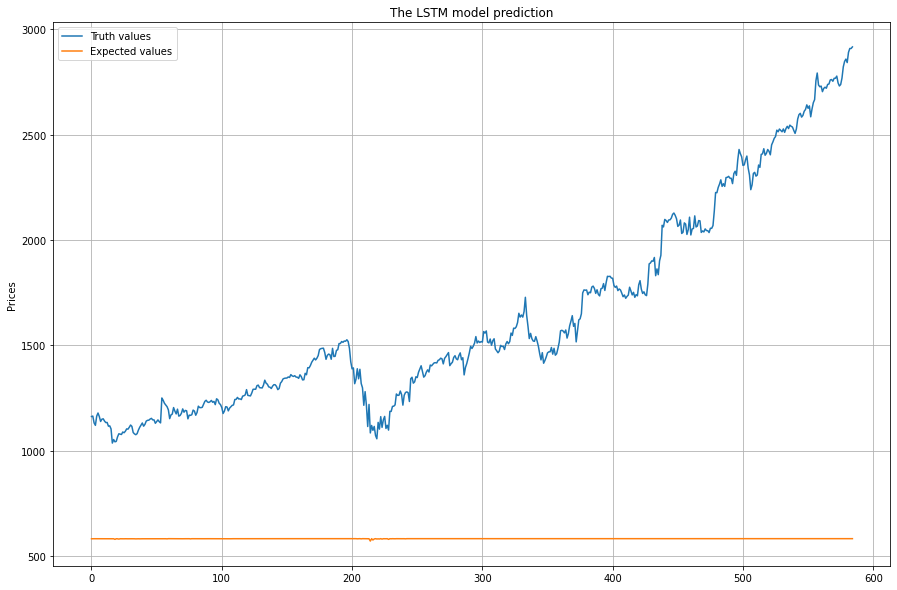

In [ ]:
y_pred = model6.predict(x_test)
model6_res = model_results(y_test, tf.squeeze(y_pred))
print(model6_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The LSTM model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

This result comes from the default parameters of LSTM layer. That is why activation parameters will be changed

In [ ]:
# other model assign the model6 to this one

inputs = tf.keras.Input(shape=(WINDOW_SIZE, ), name='input_layer')
x = expanding_layer(inputs)
x = tf.keras.layers.LSTM(128, activation='relu',
                         return_sequences=True, name='lstm_layer1')(x)
x = tf.keras.layers.Dropout(0.2, name='dropout_layer')(x)
x = tf.keras.layers.LSTM(128, activation='relu',
                        return_sequences=True, name='lstm_layer2')(x)
x = tf.keras.layers.Dense(64, activation=None, name='dense_layer')(x)                   
x = tf.keras.layers.BatchNormalization(name='batch_norm_layer')(x)
x = tf.keras.activations.relu(x)

outputs = tf.keras.layers.Dense(1, activation='linear', name='output_layer')(x)

model6 = tf.keras.Model(inputs, outputs, name='model6_lstm2')

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss=tf.keras.losses.MeanAbsoluteError(),
               )
model6.summary()

Model: "model6_lstm2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
expand_layer (Lambda)        (None, 1, 7)              0         
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 1, 128)            69632     
_________________________________________________________________
dropout_layer (Dropout)      (None, 1, 128)            0         
_________________________________________________________________
lstm_layer2 (LSTM)           (None, 1, 128)            131584    
_________________________________________________________________
dense_layer (Dense)          (None, 1, 64)             8256      
_________________________________________________________________
batch_norm_layer (BatchNorma (None, 1, 64)            

In [ ]:
BATCH_SIZE = 64
hist6 = model6.fit(x_train, 
                   y_train, 
                   verbose=1,
                   epochs=100,
                   batch_size=BATCH_SIZE,
                   validation_data=(x_test, y_test),
                   validation_steps=10,
                   callbacks=create_model_checkpoint("lstm_model"))

Epoch 1/100
37/37 [==============================] - 4s 29ms/step - loss: 604.2766 - val_loss: 1622.4398
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 2/100
37/37 [==============================] - 1s 18ms/step - loss: 602.7584 - val_loss: 1618.2684
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 3/100
37/37 [==============================] - 1s 17ms/step - loss: 601.2355 - val_loss: 1613.8165
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 4/100
37/37 [==============================] - 1s 17ms/step - loss: 599.6252 - val_loss: 1614.1656
Epoch 5/100
37/37 [==============================] - 1s 16ms/step - loss: 597.7862 - val_loss: 1613.6130
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 6/100
37/37 [==============================] - 1s 17ms/step - loss: 595.6468 - val_loss: 1604.7634
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 7/100
37/37 [==============================] - 1s 17ms/step - loss: 593.1992 - val_loss: 1598.6217
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 8/100
37/37 [==============================] - 1s 17ms/step - loss: 590.3190 - val_loss: 1597.8003
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 9/100
37/37 [==============================] - 1s 17ms/step - loss: 587.1111 - val_loss: 1587.1122
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 10/100
37/37 [==============================] - 1s 18ms/step - loss: 583.3979 - val_loss: 1586.7233
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 11/100
37/37 [==============================] - 1s 16ms/step - loss: 579.3240 - val_loss: 1579.2405
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 12/100
37/37 [==============================] - 1s 17ms/step - loss: 574.7594 - val_loss: 1574.0056
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 13/100
37/37 [==============================] - 1s 17ms/step - loss: 569.5290 - val_loss: 1564.8419
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 14/100
37/37 [==============================] - 1s 16ms/step - loss: 563.9658 - val_loss: 1557.5684
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 15/100
37/37 [==============================] - 1s 16ms/step - loss: 558.0179 - val_loss: 1552.6580
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 16/100
37/37 [==============================] - 1s 16ms/step - loss: 551.3869 - val_loss: 1547.9780
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 17/100
37/37 [==============================] - 1s 18ms/step - loss: 544.2204 - val_loss: 1543.7932
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 18/100
37/37 [==============================] - 1s 17ms/step - loss: 536.6537 - val_loss: 1534.4011
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 19/100
37/37 [==============================] - 1s 18ms/step - loss: 528.6428 - val_loss: 1526.6306
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 20/100
37/37 [==============================] - 1s 17ms/step - loss: 520.0246 - val_loss: 1510.3077
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 21/100
37/37 [==============================] - 1s 17ms/step - loss: 511.0409 - val_loss: 1494.6084
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 22/100
37/37 [==============================] - 1s 17ms/step - loss: 501.5864 - val_loss: 1465.0328
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 23/100
37/37 [==============================] - 1s 17ms/step - loss: 491.4784 - val_loss: 1479.5416
Epoch 24/100
37/37 [==============================] - 1s 17ms/step - loss: 480.9777 - val_loss: 1451.9014
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 25/100
37/37 [==============================] - 1s 18ms/step - loss: 469.9437 - val_loss: 1442.6504
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 26/100
37/37 [==============================] - 1s 17ms/step - loss: 458.5954 - val_loss: 1437.5959
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 27/100
37/37 [==============================] - 1s 18ms/step - loss: 447.2044 - val_loss: 1412.7362
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 28/100
37/37 [==============================] - 1s 17ms/step - loss: 435.4799 - val_loss: 1369.6963
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 29/100
37/37 [==============================] - 1s 17ms/step - loss: 423.1001 - val_loss: 1386.0576
Epoch 30/100
37/37 [==============================] - 1s 17ms/step - loss: 410.9239 - val_loss: 1347.0653
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 31/100
37/37 [==============================] - 1s 16ms/step - loss: 398.8202 - val_loss: 1305.5950
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 32/100
37/37 [==============================] - 1s 17ms/step - loss: 386.1187 - val_loss: 1229.3497
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 33/100
37/37 [==============================] - 1s 18ms/step - loss: 373.5020 - val_loss: 1171.7927
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 34/100
37/37 [==============================] - 1s 16ms/step - loss: 358.0975 - val_loss: 1119.2267
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 35/100
37/37 [==============================] - 1s 16ms/step - loss: 344.3506 - val_loss: 1089.1617
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 36/100
37/37 [==============================] - 1s 18ms/step - loss: 331.1315 - val_loss: 1146.0475
Epoch 37/100
37/37 [==============================] - 1s 18ms/step - loss: 316.8953 - val_loss: 1096.2977
Epoch 38/100
37/37 [==============================] - 1s 16ms/step - loss: 300.9581 - val_loss: 1071.5961
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 39/100
37/37 [==============================] - 1s 18ms/step - loss: 285.5085 - val_loss: 1060.2737
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 40/100
37/37 [==============================] - 1s 17ms/step - loss: 269.5956 - val_loss: 1013.0089
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 41/100
37/37 [==============================] - 1s 17ms/step - loss: 253.0839 - val_loss: 1043.2635
Epoch 42/100
37/37 [==============================] - 1s 16ms/step - loss: 235.0661 - val_loss: 989.7722
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 43/100
37/37 [==============================] - 1s 17ms/step - loss: 215.2223 - val_loss: 923.1452
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 44/100
37/37 [==============================] - 1s 16ms/step - loss: 197.2803 - val_loss: 933.3001
Epoch 45/100
37/37 [==============================] - 1s 16ms/step - loss: 177.8773 - val_loss: 955.1555
Epoch 46/100
37/37 [==============================] - 1s 17ms/step - loss: 167.7945 - val_loss: 654.3896
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 47/100
37/37 [==============================] - 1s 17ms/step - loss: 142.2811 - val_loss: 633.8423
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 48/100
37/37 [==============================] - 1s 17ms/step - loss: 122.6582 - val_loss: 679.1213
Epoch 49/100
37/37 [==============================] - 1s 17ms/step - loss: 104.2138 - val_loss: 651.1865
Epoch 50/100
37/37 [==============================] - 1s 16ms/step - loss: 90.9874 - val_loss: 663.2617
Epoch 51/100
37/37 [==============================] - 1s 18ms/step - loss: 73.5537 - val_loss: 630.1779
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 52/100
37/37 [==============================] - 1s 16ms/step - loss: 61.2372 - val_loss: 563.9755
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 53/100
37/37 [==============================] - 1s 18ms/step - loss: 50.1971 - val_loss: 479.0379
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 54/100
37/37 [==============================] - 1s 18ms/step - loss: 44.6433 - val_loss: 541.7908
Epoch 55/100
37/37 [==============================] - 1s 18ms/step - loss: 40.4515 - val_loss: 417.0936
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 56/100
37/37 [==============================] - 1s 17ms/step - loss: 46.8113 - val_loss: 399.4855
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 57/100
37/37 [==============================] - 1s 17ms/step - loss: 40.7517 - val_loss: 311.2799
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 58/100
37/37 [==============================] - 1s 16ms/step - loss: 46.9244 - val_loss: 213.8707
INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 59/100
37/37 [==============================] - 1s 17ms/step - loss: 42.8141 - val_loss: 294.0860
Epoch 60/100
37/37 [==============================] - 1s 17ms/step - loss: 38.6946 - val_loss: 344.2032
Epoch 61/100
37/37 [==============================] - 1s 18ms/step - loss: 35.2162 - val_loss: 304.6961
Epoch 62/100
37/37 [==============================] - 1s 16ms/step - loss: 36.6592 - val_loss: 358.9706
Epoch 63/100
37/37 [==============================] - 1s 17ms/step - loss: 42.7576 - val_loss: 257.9854
Epoch 64/100
37/37 [==============================] - 1s 18ms/step - loss: 36.1404 - val_loss: 356.4276
Epoch 65/100
37/37 [==============================] - 1s 17ms/step - loss: 40.1474 - val_loss: 325.1194
Epoch 66/100
37/37 [==============================] - 1s 16ms/step - loss: 35.8483 - val_loss: 412.4711
Epoch 67/100
37/37 [==============================] - 1s 17ms/step - loss: 38.0423 - val_loss: 261.3548
Epoch 68/100
37/37 [==============================] - 1s 17ms/st

INFO:tensorflow:Assets written to: model_experiments/lstm_model/assets


Epoch 88/100
37/37 [==============================] - 1s 18ms/step - loss: 38.9959 - val_loss: 217.5544
Epoch 89/100
37/37 [==============================] - 1s 17ms/step - loss: 34.8359 - val_loss: 279.1479
Epoch 90/100
37/37 [==============================] - 1s 17ms/step - loss: 34.9491 - val_loss: 326.6946
Epoch 91/100
37/37 [==============================] - 1s 17ms/step - loss: 33.8369 - val_loss: 342.9304
Epoch 92/100
37/37 [==============================] - 1s 18ms/step - loss: 36.2651 - val_loss: 295.8208
Epoch 93/100
37/37 [==============================] - 1s 17ms/step - loss: 39.5044 - val_loss: 317.0815
Epoch 94/100
37/37 [==============================] - 1s 17ms/step - loss: 41.6325 - val_loss: 288.1695
Epoch 95/100
37/37 [==============================] - 1s 17ms/step - loss: 36.6411 - val_loss: 296.8614
Epoch 96/100
37/37 [==============================] - 1s 18ms/step - loss: 37.3817 - val_loss: 334.7811
Epoch 97/100
37/37 [==============================] - 1s 16ms/st

In [ ]:
model6 = tf.keras.models.load_model('model_experiments/lstm_model')
model6.evaluate(x_test, y_test)

19/19 [==============================] - 1s 4ms/step - loss: 213.2763


213.2763214111328

{'mae': 213.27634, 'rmse': 223.38228, 'mase': 0.9872906}


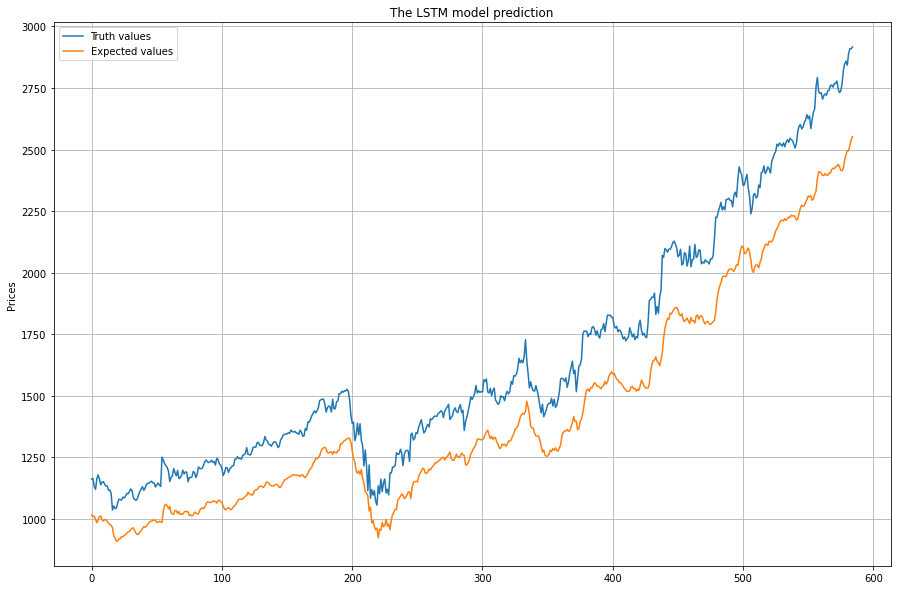

In [ ]:
y_pred = model6.predict(x_test)
model6_res = model_results(y_test, tf.squeeze(y_pred))
print(model6_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The LSTM model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In [ ]:
# before going further check all previous model results

models_res = [model0_res,
              model1_ma,
              model1_maw,
              model2_res,
              model3_res,
              model4_res,
              model5_res,
              model6_res]
for i in range(len(models_res)):
  print(models_res[i]['mae'])

20.201494
352.82217
14.646487
146.31886
27.126118
20.832087
19.889507
213.27634


Still best performer is moving average with 3 window sized

# Model 6: N-BEATS algorithm

Algorithm will be structured by this paper https://arxiv.org/pdf/1905.10437.pdf

Algorithm consists of 3 block
 
 1) Fully coneccted block which has 2 outputs
 
 2) 2 residual blocks

### Fully connected block class

The architecture first step is fully connected block of multiple dense layers with relu activations and output layer with linear function activation function. Block outputs 2 submatrixes, one for backcasting other more important with forecasting

In [ ]:
class NBEATSblock(tf.keras.layers.Layer):

  def __init__(self, input_size, theta_shape, horizon, n_neurons, n_layers, **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_shape = theta_shape
    # self.window = window
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # fc block consists of n layers(in paper suggested 4)
    self.hidden = [tf.keras.layers.Dense(self.n_neurons, activation='relu', 
                                         name=f'fc_layer_{i}') for i in range(self.n_layers)]
    # output layer will be theta sized dense from which then backcast and forwardcast will be taken
    self.theta = tf.keras.layers.Dense(self.theta_shape, activation='linear', name='output_layer')

  def call(self, input):
    
    x = input
    for layer in self.hidden.layers:
      x = layer(x)
    theta = self.theta(x)
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


In [ ]:
# initilize the block
nbeat_block = NBEATSblock(input_size=WINDOW_SIZE,
                          theta_shape=WINDOW_SIZE + HORIZON,
                          horizon=HORIZON,
                          n_neurons=128,
                          n_layers=4)

In [ ]:
# checking the output from layer
exp_input = tf.expand_dims(input=[100, 300, 500, 1000, 1200, 1300, 1500], axis=0)
exp_input = tf.cast(exp_input, dtype=tf.float32)
nbeat_block(exp_input)

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 139.88104 ,  -17.501724, -111.18408 ,  -53.104095,  -50.932556,
           61.196983,  -16.154163]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[13.808975]], dtype=float32)>)

### Creating dataset with `tf.data`

As model will be large it is suggested to use tf.data 

In [ ]:
# set global varibles
WINDOW_SIZE = 7
HORIZON = 1
TEST_SIZE = 0.2
x_train, x_test, y_train, y_test = train_test_datasets(close,
                                                       WINDOW_SIZE,
                                                       HORIZON,
                                                       TEST_SIZE)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2345, 7), (585, 7), (2345,), (585,))

In [ ]:
# creating tf datasets
BATCH_SIZE = 1024 # from paper
df_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
df_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Defining the hyperparameters from paper

In [ ]:
N_NEURONS = 512
N_LAYERS = 4
BLOCK = 1
N_EPOCHS = 5000

N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE + HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

### Setup residuals connection and architect the model

1. Initilaze `NBEATSblock` instance
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using tf.keras.Model()
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [ ]:
subtract_layer = tf.keras.layers.Subtract()
add_layer = tf.keras.layers.Add()

layer1 = tf.constant([1.0, 2.0, 3.0], dtype=tf.float32)
layer2 = tf.constant([5.0, 7.0, 9.0], dtype=tf.float32)
x = tf.zeros(shape=layer1.shape)
y = tf.zeros(shape=layer1.shape)
for i in range(5):
  x += add_layer([layer1, layer2])
  print(x)
  y = add_layer([y, layer1])
  print(y)

tf.Tensor([ 6.  9. 12.], shape=(3,), dtype=float32)
tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32)
tf.Tensor([12. 18. 24.], shape=(3,), dtype=float32)
tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
tf.Tensor([18. 27. 36.], shape=(3,), dtype=float32)
tf.Tensor([3. 6. 9.], shape=(3,), dtype=float32)
tf.Tensor([24. 36. 48.], shape=(3,), dtype=float32)
tf.Tensor([ 4.  8. 12.], shape=(3,), dtype=float32)
tf.Tensor([30. 45. 60.], shape=(3,), dtype=float32)
tf.Tensor([ 5. 10. 15.], shape=(3,), dtype=float32)


In [ ]:
class ResidualBlock(NBEATSblock):

  def __init__(self, n_blocks, input_size, theta_shape, horizon, n_neurons, n_layers, **kwargs):
    self.n_blocks = n_blocks
    super().__init__(input_size, theta_shape, horizon, n_neurons, n_layers)
    NBEATSblock.input_size = input_size
    NBEATSblock.theta_shape = theta_shape
    NBEATSblock.horizon = horizon
    NBEATSblock.n_neurons = n_neurons
    NBEATSblock.n_layers = n_layers

  def call(self, inputs):
    back = tf.zeros(shape=self.input_size, dtype=tf.float32)
    fore = tf.zeros(shape=self.horizon, dtype=tf.float32)

    for i in range(self.n_blocks):
      backcast, forecast = NBEATSblock.call(input=inputs)
      back += tf.keras.layers.Subtract([backcast, inputs])
      fore += tf.keras.layers.Add([forecast])
      inputs = back
    
    return back, fore
  
residual_block = ResidualBlock(n_blocks=5,
                               input_size=7,
                               theta_shape=8,
                               horizon=1,
                               n_neurons=128,
                               n_layers=4)

residual_block(exp_input)


In [ ]:
# 1 create nbeats block
nbeat_block = NBEATSblock(input_size=INPUT_SIZE,
                          theta_shape=THETA_SIZE,
                          horizon=HORIZON,
                          n_neurons=N_NEURONS,
                          n_layers=N_LAYERS,
                          name='nbeat_block_0')
# 2 create stack input layer
stack_input = tf.keras.Input(shape=(WINDOW_SIZE, ), name='stacked_layer')

# 3 initialize first forecast and backcast outputs from nbeat_block
residuals, forecast = nbeat_block(stack_input)

# 4 for loop for block layers
for i, _ in enumerate(range(N_STACKS-1)):
  
  # 5 for each loop call nbeat block
  nbeats_new_block = NBEATSblock(input_size=INPUT_SIZE,
                                                theta_shape=THETA_SIZE,
                                                horizon=HORIZON,
                                                n_neurons=N_NEURONS,
                                                n_layers=N_LAYERS,
                                                name=f'nbeat_block_{i+1}')
  block_backcast, block_forecast = nbeats_new_block(residuals)
                          
  # 6 create residual stacking
  residuals = tf.keras.layers.subtract([residuals, block_backcast], name=f"subtracting_layer_{i}")
  forecast = tf.keras.layers.add([forecast, block_forecast], name=f"adding_layer_{i}")


model7 = tf.keras.Model(stack_input, forecast, name='model7_nbeats')


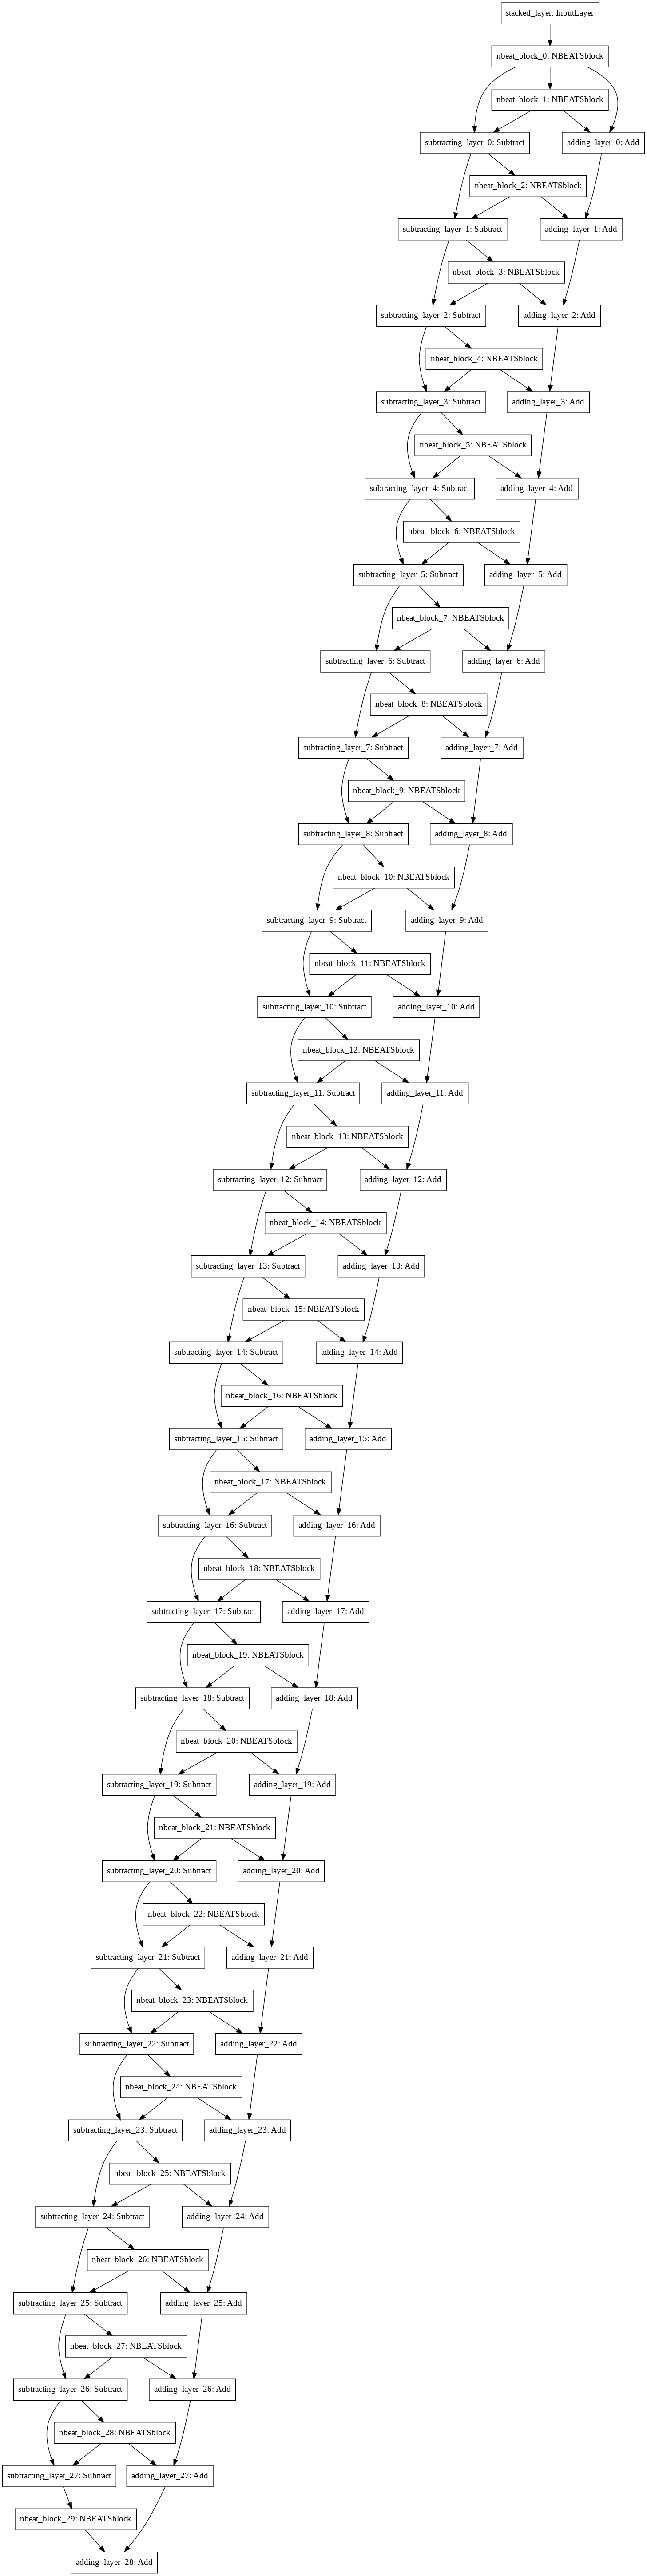

In [ ]:
tf.keras.utils.plot_model(model7)

In [ ]:
model7.compile(loss="mae",
               optimizer=tf.keras.optimizers.Adam())

In [ ]:
!nvidia-smi

Sun Sep  5 15:55:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model7.fit(df_train,
          verbose=0,
          epochs=N_EPOCHS,
          validation_data=df_test,
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=200,
                                                      restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                          patience=100,
                                                          verbose=1),
                    ]
           )


Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00296: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [ ]:
model7.evaluate(df_test)

1/1 [==============================] - 0s 55ms/step - loss: 26.3459


26.345903396606445

{'mae': 26.345903, 'rmse': 37.293423, 'mase': 0.8124869}


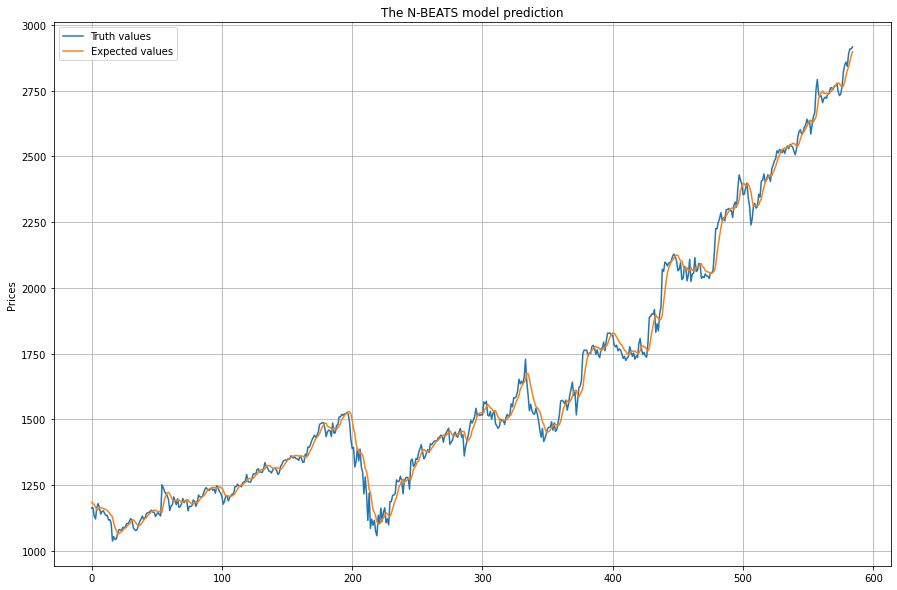

In [ ]:
y_pred = model7.predict(x_test)
model7_res = model_results(y_test, tf.squeeze(y_pred))
print(model7_res)
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The N-BEATS model prediction")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

# Model 7 : Ensemble models

Like in NBEATS paper this time different models will be trained with 3 different losses
But this case each model will be more simple:
Conv1D layer and GlobalAveragePooling layer.
10 interations will be made and 3 losses will be used e. g. 30 loops, then each model will be saved in list, after training all models, each model will be evaluated and mean or median will be taken as output


### Creating the trained ensemble models list 

In [ ]:
def get_ensemple_models(window, horizon, train_data, test_data, num_iter, num_epochs, losses=['mae', 'mse', 'mape']):
  # all models will be saved in list
  models = []
  for i, _ in enumerate(range(num_iter)):
    # different loop for each loss function
    for loss in losses:
      inputs = tf.keras.Input(shape=(window, ))
      x = tf.expand_dims(inputs, axis=1)
      x = tf.keras.layers.Conv1D(128, kernel_size=window,
                                strides=1, padding='causal',
                                activation='linear'
                                )(x)

      x = tf.keras.layers.GlobalMaxPooling1D()(x)
      outputs = tf.keras.layers.Dense(horizon, activation='linear')(x)

      model = tf.keras.Model(inputs, outputs) 

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss=loss)
      model.fit(train_data, 
                epochs=num_epochs, 
                validation_data=test_data, 
                verbose=0,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      models.append(model)
  return models

In [ ]:
%%time
ensemble_models = get_ensemple_models(window=WINDOW_SIZE,
                                      horizon=HORIZON,
                                      train_data=df_train,
                                      test_data=df_test,
                                      num_iter=10,
                                      num_epochs=1000)


Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00230: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00607: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00708: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00808: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00125: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00225: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00927: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00229: Re

In [ ]:
# create matrix where each row is the prediction of one of ensemble models
# then final prediction will be taken mean and median for each column
shape = 585
preds = np.zeros(shape=(len(ensemble_models), shape))
for i in range(len(ensemble_models)):
  preds[i, :] = ensemble_models[i].predict(x_test).reshape(shape, )
preds


array([[1174.1628418 , 1166.60522461, 1165.94213867, ..., 2878.39306641,
        2900.06811523, 2910.78808594],
       [1177.83935547, 1172.61254883, 1171.37939453, ..., 2835.0690918 ,
        2854.23754883, 2878.68994141],
       [1170.07104492, 1165.10375977, 1167.64904785, ..., 2893.50708008,
        2916.03442383, 2920.55981445],
       ...,
       [1174.56066895, 1166.51318359, 1165.75476074, ..., 2876.93139648,
        2898.41479492, 2910.99951172],
       [1188.43286133, 1185.81188965, 1183.30187988, ..., 2852.09887695,
        2868.32861328, 2891.52636719],
       [1169.07312012, 1165.10302734, 1166.44421387, ..., 2888.94482422,
        2914.77050781, 2917.58911133]])

In [ ]:
# evaluating the results
preds_mean = preds.mean(axis=0)
preds_median = np.median(preds, axis=0)

print("Ensemble predictions results output taken as MEAN of each expert")
print(model_results(y_test, preds_mean))

print("Ensemble predictions results output taken as MEDIAN of each expert")
print(model_results(y_test, preds_median))

Ensemble predictions results output taken as MEAN of each expert
{'mae': 22.22532, 'rmse': 31.541487, 'mase': 0.75938654}
Ensemble predictions results output taken as MEDIAN of each expert
{'mae': 20.955568, 'rmse': 30.003813, 'mase': 0.7344545}


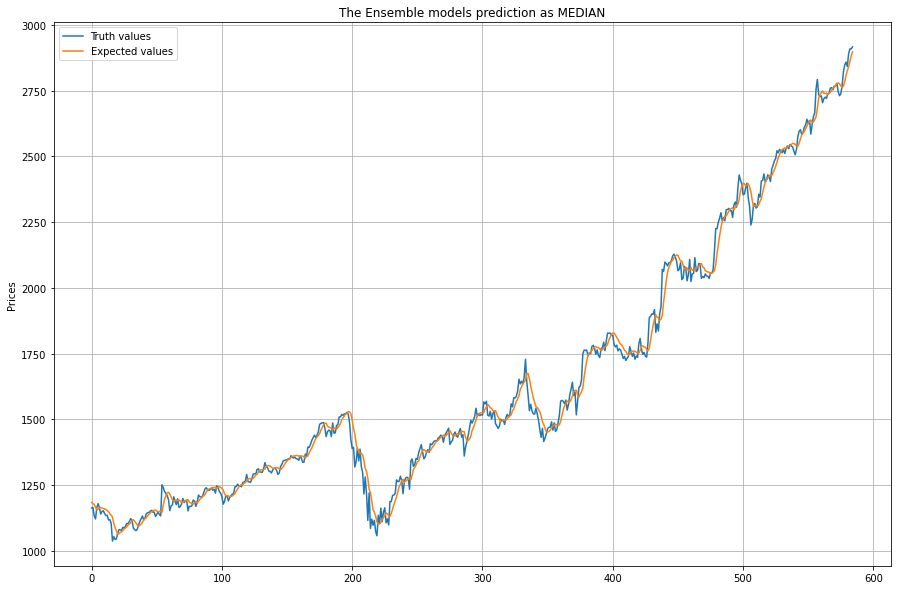

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=np.squeeze(y_pred), label='Expected values')
plt.title("The Ensemble models prediction as MEDIAN")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

In evaluating the final results from ensembles each model has equivalent weight however there maybe can be models which will predict better than other.

### Getting the best performed models and evaluating

In [ ]:
for i, _ in enumerate(range(preds.shape[0])):
  y_pred = ensemble_models[i].predict(x_test)
  print(f"{i + 1} model results \n {model_results(y_test, tf.squeeze(y_pred))} \n ")


1 model results 
 {'mae': 20.890324, 'rmse': 29.895412, 'mase': 0.73830533} 
 
2 model results 
 {'mae': 30.464369, 'rmse': 41.935978, 'mase': 0.83976066} 
 
3 model results 
 {'mae': 19.819939, 'rmse': 28.846483, 'mase': 0.7268091} 
 
4 model results 
 {'mae': 21.409307, 'rmse': 30.386713, 'mase': 0.73679906} 
 
5 model results 
 {'mae': 30.088045, 'rmse': 42.360523, 'mase': 0.8501998} 
 
6 model results 
 {'mae': 20.102076, 'rmse': 28.830189, 'mase': 0.72722894} 
 
7 model results 
 {'mae': 21.327003, 'rmse': 30.281033, 'mase': 0.7367114} 
 
8 model results 
 {'mae': 33.670845, 'rmse': 47.137737, 'mase': 0.8804554} 
 
9 model results 
 {'mae': 19.718159, 'rmse': 28.74237, 'mase': 0.72047037} 
 
10 model results 
 {'mae': 21.656662, 'rmse': 30.72359, 'mase': 0.7424325} 
 
11 model results 
 {'mae': 32.134785, 'rmse': 44.95054, 'mase': 0.8646406} 
 
12 model results 
 {'mae': 19.96236, 'rmse': 28.816994, 'mase': 0.7240123} 
 
13 model results 
 {'mae': 21.416574, 'rmse': 30.516771, 'ma

In [ ]:
# take the model corresponding index where the mae is lower 22.0
best_models = []
for i in range(len(ensemble_models)):
  y_pred = ensemble_models[i].predict(x_test)
  if model_results(y_test, tf.squeeze(y_pred))['mae'] < 22.0:
    best_models.append(ensemble_models[i])
# taking only the best performed models
print(f"The quantiity of best models are {len(best_models)}")

shape = 585
preds_new = np.zeros(shape=(len(best_models), shape))
for i in range(len(best_models)):
  preds_new[i, :] = best_models[i].predict(x_test).reshape(shape, )

# evaluating the results and comparing with all ensembles results
preds_mean_new = preds_new.mean(axis=0)
preds_median_new = np.median(preds_new, axis=0)

print("Ensemble predictions results output taken as MEAN of each expert")
print(model_results(y_test, preds_mean))

print("Ensemble predictions results output taken as MEDIAN of each expert")
print(model_results(y_test, preds_median))
print()
print("******************************************************************")
print()
print("Ensemble predictions results from chosen output taken as MEAN of each expert")
print(model_results(y_test, preds_mean_new))

print("Ensemble predictions results from chosen output taken as MEDIAN of each expert")
print(model_results(y_test, preds_median_new))



The quantiity of best models are 19
Ensemble predictions results output taken as MEAN of each expert
{'mae': 22.22532, 'rmse': 31.541487, 'mase': 0.75938654}
Ensemble predictions results output taken as MEDIAN of each expert
{'mae': 20.955568, 'rmse': 30.003813, 'mase': 0.7344545}

******************************************************************

Ensemble predictions results from chosen output taken as MEAN of each expert
{'mae': 20.252747, 'rmse': 29.153181, 'mase': 0.72590536}
Ensemble predictions results from chosen output taken as MEDIAN of each expert
{'mae': 20.139957, 'rmse': 29.01365, 'mase': 0.72485596}


The loss is decreased but very only a few. It can additional be tried to use more models or other model architecture

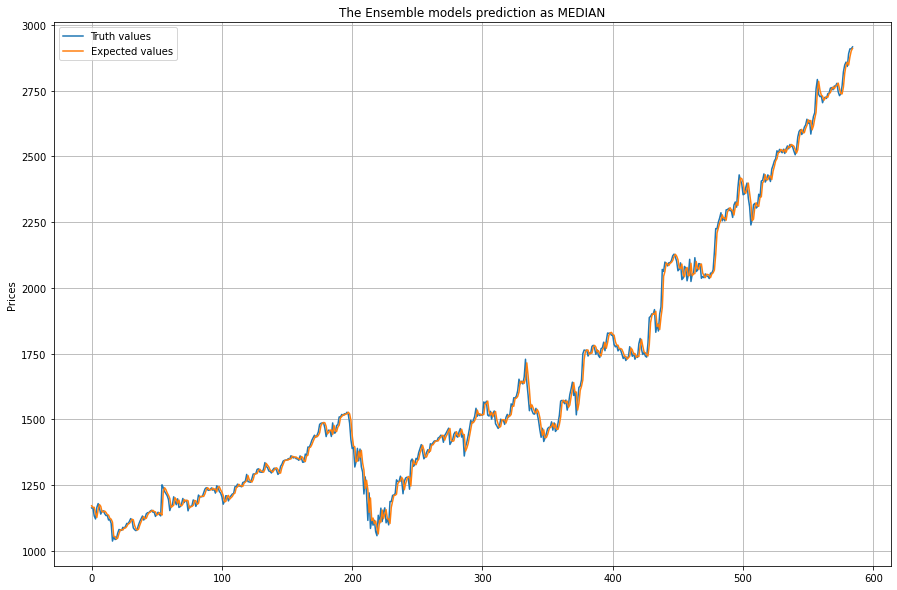

In [ ]:
plt.figure(figsize=(15, 10))
sns.lineplot(x=np.arange(0, len(y_test)), y=y_test, label='Truth values')
sns.lineplot(x=np.arange(0, len(y_test)), y=preds_median_new, label='Expected values')
plt.title("The Ensemble models prediction as MEDIAN")
# plt.xlabel("Dates")
plt.ylabel('Prices')
plt.grid()
plt.show()

### Visualizing the predictions with maximum and minimum amounts intervals not point predictions

In [ ]:
# define a function for visualization
def visual_results(y_true, ens_preds):
  # maximum, minimum, mean and median for each predictions e. g. for each column
  maxx = ens_preds.max(axis=0)
  minn = ens_preds.min(axis=0)
  med = np.median(ens_preds, axis=0)
  means = np.mean(ens_preds, axis=0)
  x = np.arange(len(y_true))

  plt.figure(figsize=(12, 7))
  plt.plot(x, y_true, 'o', color='r', label='Truth values')
  plt.plot(x, med, label='Median of predictions')
  plt.plot(x, means, label='Mean of predictions')
  plt.fill_between(x, maxx, minn, color='b',alpha=.15)
  plt.legend()
  plt.xlabel("Time Periods")
  plt.ylabel("Prices")
  plt.title("Ensemble models results")
  plt.grid()
  plt.show()

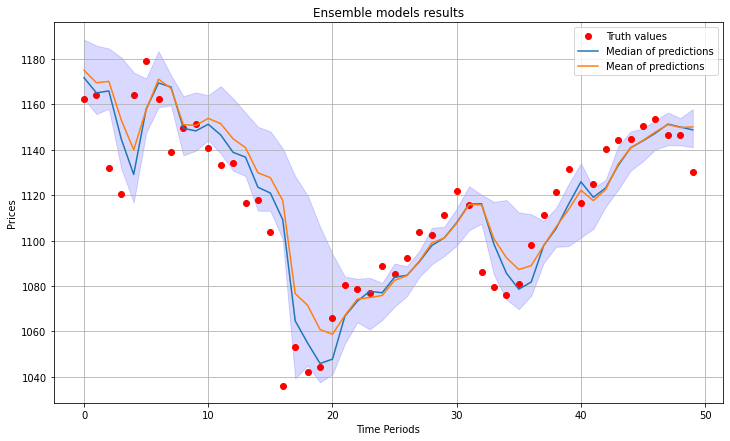

In [ ]:
visual_results(y_true=y_test[:50],
               ens_preds=preds[:, :50])

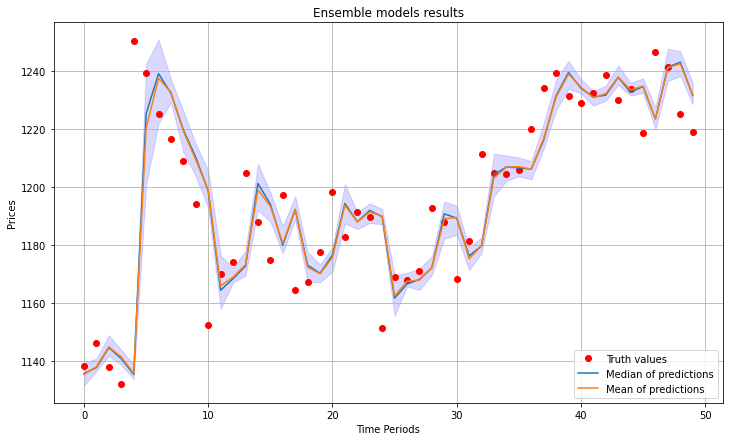

In [ ]:
visual_results(y_true=y_test[50:100],
               ens_preds=preds_new[:, 50:100])

### Visualizing the predictions with std and mean amounts intervals not point predictions

In [ ]:

def visual_results_std(y_true, ens_preds):
  
  stds = np.std(ens_preds, axis=0)
  means = np.mean(ens_preds, axis=0)
  x = np.arange(len(y_true))

  intervals = 1.96 * stds
  upper_bounds = means + intervals
  lower_bounds = means - intervals

  plt.figure(figsize=(12, 7))
  plt.plot(x, y_true, color='r', label='Truth values')
  plt.plot(x, means, label='Mean of predictions')
  plt.fill_between(x, upper_bounds, lower_bounds, color='b',alpha=.15)
  plt.legend()
  plt.xlabel("Time Periods")
  plt.ylabel("Prices")
  plt.title("Ensemble models results")
  plt.grid()
  plt.show()

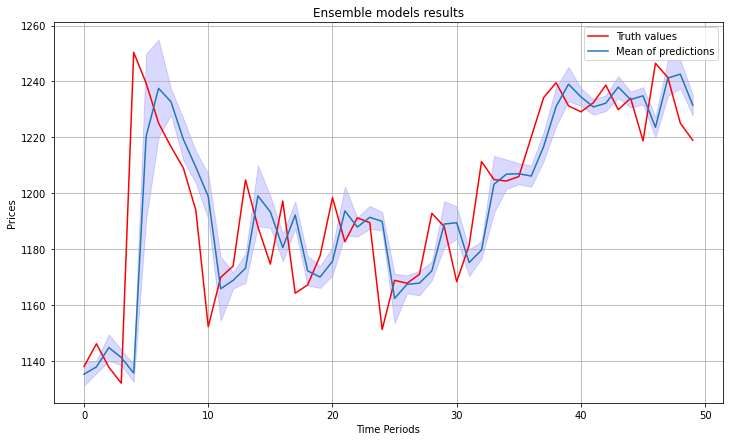

In [ ]:
visual_results_std(y_true=y_test[50:100],
               ens_preds=preds_new[:, 50:100])

It still can be seen that model has lags with 1 period

# Comparing results

In [ ]:
model8_ensemble_all = model_results(y_test, preds_median)
model8_ensemble_best = model_results(y_test, preds_median_new)

results = [model0_res, model1_ma, model1_maw, model2_res, model3_res, model4_res, model5_res, model6_res, 
           model7_res, model8_ensemble_all, model8_ensemble_best]
results = pd.DataFrame(results)
results.index = ['naive_model', 'moving_average', 'moving_average_3days', 
                 'dense_model_7_window', 'dense_model_30_window',
                 'conv1d_model_1', "conv1d_model_2", "lstm_model",
                 'n-beats_algorithm_model', 'ensemble_model', 
                 'best_estimators']
results

,mae,rmse,mase
naive_model,20.201494,29.204773,0.729932
moving_average,352.822174,492.734985,0.995382
moving_average_3days,14.646487,20.685097,0.597160
dense_model_7_window,146.318863,161.123215,0.968973
dense_model_30_window,27.126118,35.895275,0.782309
conv1d_model_1,20.832087,29.919538,0.740874
conv1d_model_2,19.889507,28.821043,0.723151
lstm_model,213.276337,223.382278,0.987291
n-beats_algorithm_model,26.345903,37.293423,0.812487
ensemble_model,20.955568,30.003813,0.734455


# Conclusion

The best performed moving average of previous 3 days. However the used deep learning models also showed good results. For the further same models can be trained with different parameters: window_size, horizon, optimizer, units,
etc. Also can be implemented feature engineering for example adding S&P indexes, other BigTech companies stock prices, maybe even text data from news.

However it can be seen despite the performance of neural networks in other fields such like computer vision or NLP where DL models reached state of art, but in Time Series problems such this example it can be seen that simple approaches can perform better

In the further notebooks other methods/models will be tried